# View Landsat 8 imagery for a chosen time period

Get landsat 8 images for a given time period and lat/long extents, choose a image and plot a false color composite. Save plots, export xarray dataset to netCDF and translate to geotiff files on the command line.

Authorship: Bex Dunn, Mike Barnes, Claire Krause, Damien Ayers

## First we import the modules we need

In [22]:
%pylab notebook

import datacube
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

#import pandas as pd
import xarray as xr
import numpy as np
#import csv
import os
import sys
#import datetime

#get the DEA version of the plotting functions
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

#from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
#import matplotlib.dates
#from IPython.display import display
#import ipywidgets as widgets

import rasterio
#import urllib
#from pyproj import Proj, transform
#from dateutil import tz
#from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-plot landsat  FalseColour')

Populating the interactive namespace from numpy and matplotlib


## define a function to plot False Color composite

In [23]:
# from matplotlib.pyplot import imshow
# from skimage import exposure

# def drawFalseColour(ds, time = 0):
#     '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
#     color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
#     t, y, x = ds['green'].shape
#     rawimg = np.zeros((y,x,3), dtype = np.float32)
#     for i, colour in enumerate(['swir1', 'nir', 'green']):
#         rawimg[:,:,i] = ds[colour][time].values
#     rawimg[rawimg == -999] = np.nan
#     img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
#     fig = plt.figure(figsize=[10,10])
#     imshow(img_toshow)
#     ax = plt.gca()
#     ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
#     ax.set_xticklabels(ds.x.values)
#     ax.set_yticklabels(ds.y.values)
#     ax.set_xlabel('Eastings', fontweight = 'bold')
#     ax.set_ylabel('Northings', fontweight = 'bold')

## Complete Datacube query

### Edit the start and end dates and spatial bounds here if you wish ***

In [24]:
#Spatiotemporal range and wavelengths/band of interest are defined

#Temporal range is defined
start_of_epoch = '2016-12-01'
end_of_epoch =  '2017-01-30'

#Wavelengths/bands of interest are defined
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Sensors of interest are defined
sensors = ['ls8']#,"
    #'ls7',
    #'ls5' ] 


#Create bounding box around the location of the stream gauge
lat_max = -19.79
lat_min = -19.85
lon_max = 145.34
lon_min = 145.27

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [25]:
print(query)

{'time': ('2016-12-01', '2017-01-30'), 'x': (145.27, 145.34), 'y': (-19.79, -19.85), 'crs': 'EPSG:4326'}


### Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

In [26]:
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

## Complete Datacube extraction
The extracted data is first filtered using the criteria in "mask_components".
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded. Change the cloud free threshold if you want less cloudy scenes.

In [27]:
sensor_clean = {}
cloud_free_threshold = 0 ###Scenes will not be retrieved that have less than the cloud threshold worth of image.


## Run the datacube extraction. This may take some time.

In [30]:
data, crs, affine = DEADataHandling.load_nbarx('ls8', query, bands_of_interest, product='nbar')

loading ls8_nbar_albers
loaded ls8_nbar_albers
making mask ls8_pq_albers
masked ls8_nbar_albers with ls8_pq_albers and filtered terrain


In [28]:
#Retrieve the data for each Landsat sensor
sensor ='ls8'
#Load the NBAR and corresponding PQ
sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                      measurements = bands_of_interest,  **query)

sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                    fuse_func=ga_pq_fuser, **query)

#     #Retrieve the projection information before masking/sorting
#     crs = sensor_nbar.crs
#     crswkt = sensor_nbar.crs.wkt
#     affine = sensor_nbar.affine

#Ensure there's PQ to go with the NBAR
sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)

#Apply the PQ masks to the NBAR
quality_mask = masking.make_mask(sensor_pq, **mask_components)
good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor_nbar2 = sensor_nbar.where(good_data)

#Calculate the percentage cloud free for each scene
cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                               contiguous=True).pixelquality
mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold

#Discard data that does not meet the cloud_free_threshold
mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
#mostly_good['product'] = ('time', numpy.repeat(sensor.encode('ascii'), mostly_good.time.size))    
nbar_clean = mostly_good

In [8]:
#Retrieve the projection information before masking/sorting
crs = sensor_nbar.crs
crswkt = sensor_nbar.crs.wkt
affine = sensor_nbar.affine

In [9]:
#sort by time, to make sure data is organised by time, then reattach attributes
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [10]:
#Check the data
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 4, x: 319, y: 296)
Coordinates:
  * time     (time) datetime64[ns] 2016-12-10T00:17:30 2016-12-26T00:17:26 ...
  * y        (y) float64 -2.193e+06 -2.193e+06 -2.193e+06 -2.193e+06 ...
  * x        (x) float64 1.382e+06 1.382e+06 1.382e+06 1.382e+06 1.382e+06 ...
Data variables:
    green    (time, y, x) float64 819.0 1.127e+03 nan nan nan nan nan nan ...
    red      (time, y, x) float64 848.0 1.188e+03 nan nan nan nan nan nan ...
    nir      (time, y, x) float64 1.379e+03 1.764e+03 nan nan nan nan nan ...
    swir1    (time, y, x) float64 1.571e+03 2.057e+03 nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1381550.00|\n| 0.00,-25.00,-2192600.00|\n| 0.00,...

## Return just the time and sensor product information from the Datacube extraction

In [11]:
product_time = nbar_clean['time'].to_dataframe() #Add time and product to dataframe
#product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [12]:
print(product_time.index)

Index(['2016-12-10', '2016-12-26', '2017-01-11', '2017-01-27'], dtype='object', name='time')


# Make a false color image

In [13]:
print(product_time.index)

Index(['2016-12-10', '2016-12-26', '2017-01-11', '2017-01-27'], dtype='object', name='time')


2016-12-10


<IPython.core.display.Javascript object>


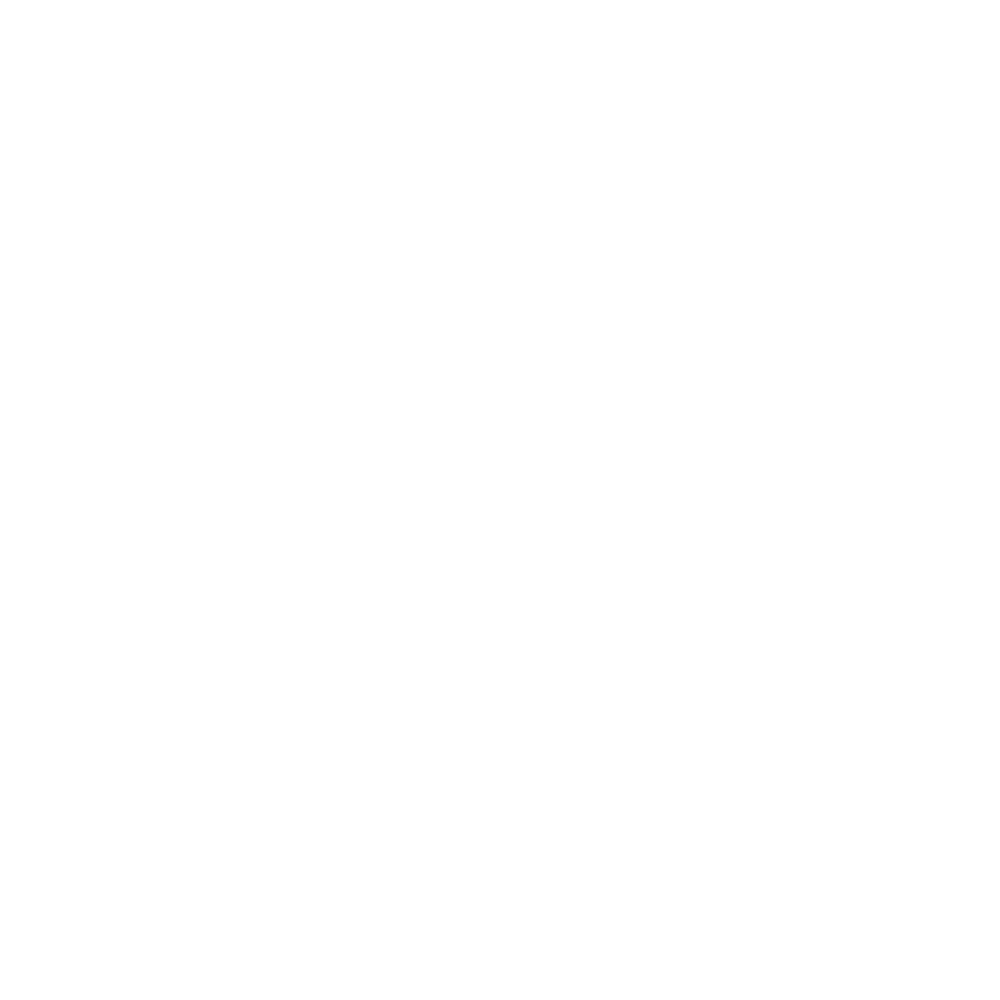

2016-12-26


<IPython.core.display.Javascript object>


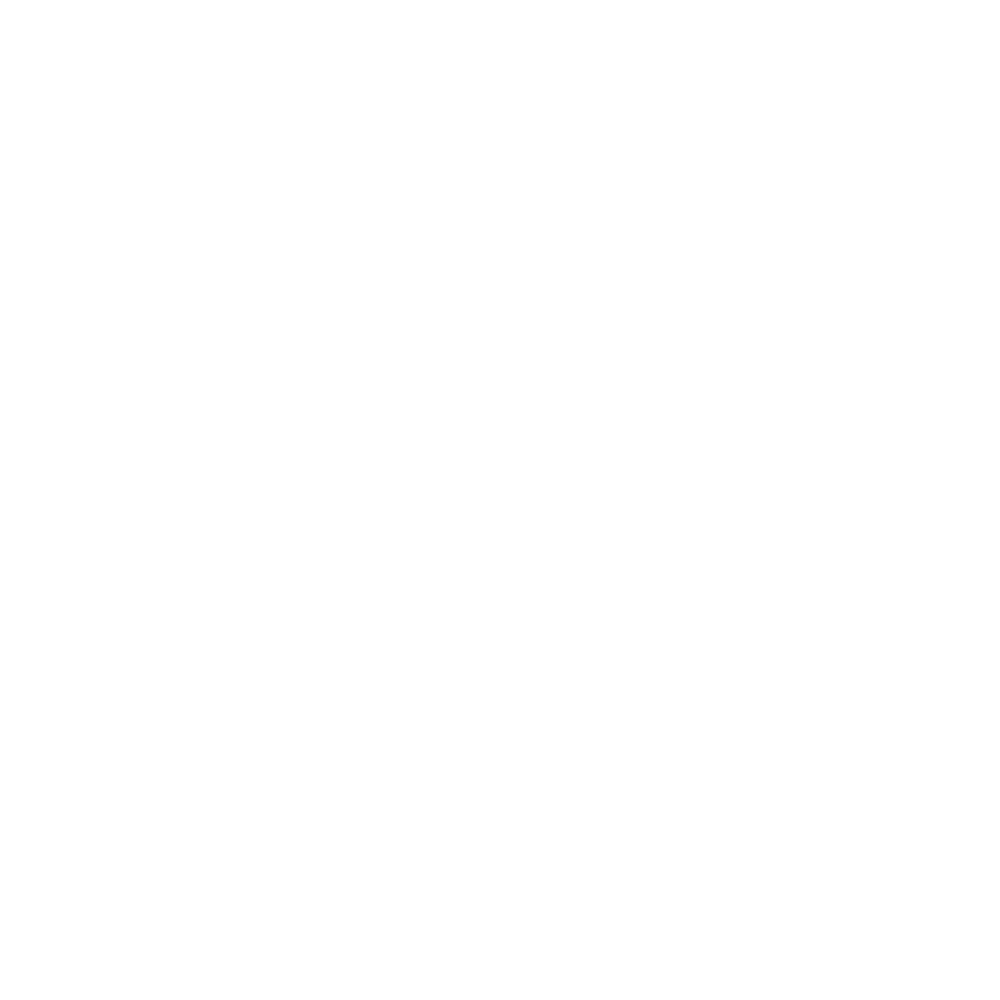

2017-01-11


<IPython.core.display.Javascript object>


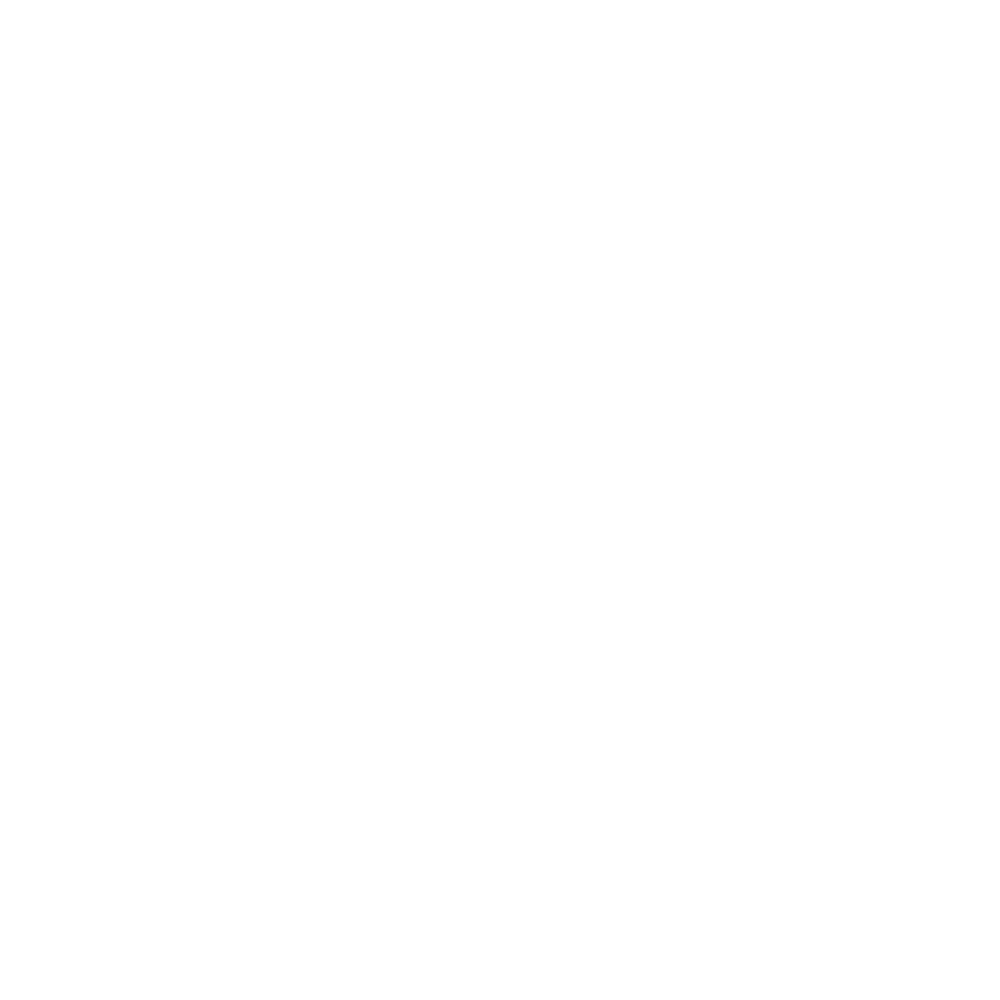

2017-01-27


<IPython.core.display.Javascript object>


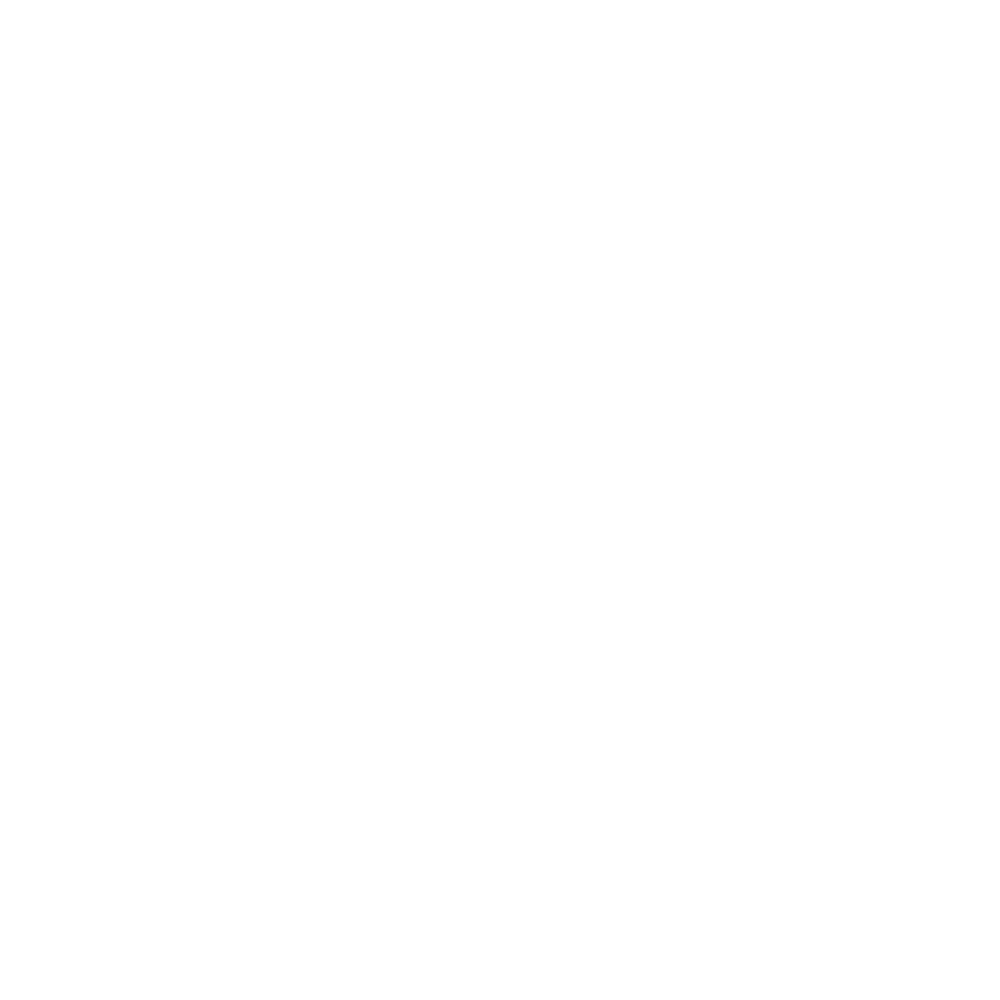

In [14]:
for i in range(0,nbar_clean.time.size):
    #print(i)
    #print('{}'.format(nbar_clean.time.values[i]))
    print('{}'.format(product_time.index[i]))
    drawFalseColour(nbar_clean, time =i)
    plt.savefig('./{}.png'.format(product_time.index[i]))
    plt.show()

# If required, save as image in netcdf format

In [15]:
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 4, x: 319, y: 296)
Coordinates:
  * time     (time) datetime64[ns] 2016-12-10T00:17:30 2016-12-26T00:17:26 ...
  * y        (y) float64 -2.193e+06 -2.193e+06 -2.193e+06 -2.193e+06 ...
  * x        (x) float64 1.382e+06 1.382e+06 1.382e+06 1.382e+06 1.382e+06 ...
Data variables:
    green    (time, y, x) float64 819.0 1.127e+03 nan nan nan nan nan nan ...
    red      (time, y, x) float64 848.0 1.188e+03 nan nan nan nan nan nan ...
    nir      (time, y, x) float64 1.379e+03 1.764e+03 nan nan nan nan nan ...
    swir1    (time, y, x) float64 1.571e+03 2.057e+03 nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1381550.00|\n| 0.00,-25.00,-2192600.00|\n| 0.00,...

In [16]:
def write_your_netcdf(data, dataset_name, filename, crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    dataset.attrs['affine'] =affine
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

### Set a save file name and directory here:

In [17]:
outfile = './test6_netcdf.nc'

In [18]:
write_your_netcdf(nbar_clean.isel(time=0), 'nbar',outfile, crs=nbar_clean.crs)

RuntimeError: Storage Unit already exists: test6_netcdf.nc


## create a geotiff for each of the bands!

## this is a command line command, change your file names to match outfile above 

In [19]:
!gdal_translate -of GTIFF -sds "./test6_netcdf.nc" "./test6_netcdf.tif"

Input file size is 319, 296
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 319, 296
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 319, 296
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 319, 296
0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
import numpy
import rasterio